In [1]:
import sys
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import torchvision
import torch
import math
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import glob
from scipy import signal
import pickle

import os
os.chdir("/home/yhbedoya/Repositories/SHM-MAE")
import models_audio_mae


/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def exp10(num):
    return 10**num

In [62]:
# define the utils

def show_image(frequencies, times, spectrogram, title='', diffFlag=False):
    #plt.figure(figsize=(10, 5))
    plt.title(f'spectrogram from PSD: {title}')
    #plt.pcolormesh(times, frequencies, 10*np.log10(np.squeeze(spectrogram)), vmin=-150, vmax=-50)
    if not diffFlag:
      plt.pcolormesh(times, frequencies, 10*np.squeeze(spectrogram), vmin=-150, vmax=-50)
    else:
      plt.pcolormesh(times, frequencies, 10*np.squeeze(spectrogram))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(format="%+2.f", label='dB')
    return

def prepare_model(chkpt_dir, arch='audioMae_vit_base'):
    # build model
    model = getattr(models_audio_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(frequencies, times, spectrogram, model, test):
    
    #gnr_mean = 7.425835578987807e-08
    #gnr_std = 5.845655574487041e-07

    originalSpect = inverseLog10(spectrogram)

    gnr_max = -0.3478935609574018
    gnr_min = -23.04051432876423

    x = torch.transpose(spectrogram, 1, 2) #shape [1,80,100]
    #x = x - gnr_mean
    #x = x / gnr_std

    #MIN MAX SCALER
    x = (x -gnr_min) /(gnr_max-gnr_min) 

    # make it a batch-like
    x = x.unsqueeze(dim=0)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.8)
    #y = model_mae.unpatchify(y).detach().cpu()
    y = y.type(torch.float64)
    y = model.unpatchify(y).detach().cpu()
    
    y = torch.transpose(torch.squeeze(torch.squeeze(input=y)),0,1)


    #y = torch.squeeze(torch.squeeze(input=out))
    y = y * (gnr_max-gnr_min) 
    y = y + gnr_min

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    #mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    mask = torch.transpose(torch.squeeze(torch.squeeze(input=mask)),0,1)
    #print(f'mask shape {mask.shape}')
    #x = torch.einsum('nchw->nhwc', x)
  

    # masked image
    spectrogram = torch.squeeze(spectrogram)

    #print(f'spectrogram shape {spectrogram.shape}')
    im_masked = spectrogram * (1 - mask)
    #print(f'inmask shape {im_masked.shape}')

    # MAE reconstruction pasted with visible patches
    im_paste = spectrogram * (1 - mask) + y * mask
    convertedSpectrogram = inverseLog10(im_paste)
    #im_paste2 = spectrogram * (1 - mask) + ((y + torch.abs(0.6*torch.min(y))) * mask)
    #print(f'im_paste shape {im_paste.shape}')

    #diff reconstruction original
    diff = torch.abs(spectrogram - im_paste)

    mse = (np.square(spectrogram - im_paste)).mean()
    originalMse = (np.square(originalSpect - convertedSpectrogram)).mean()

    if test:
      return mse, originalMse

    print(f"MSE: {mse}")

    plt.title(f"MSE: {mse}")

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [30, 8]

    plt.subplot(1, 4, 1)
    show_image(frequencies, times, spectrogram, "original")

    plt.subplot(1, 4, 2)
    show_image(frequencies, times, im_masked, "masked")

    plt.subplot(1, 4, 3)
    show_image(frequencies, times, im_paste, "reconstruction + visible")

    plt.subplot(1, 4, 4)
    show_image(frequencies, times, diff, "Difference original vs prediction", diffFlag=True)

    #plt.show()

inverseLog10 = np.vectorize(exp10)

In [2]:
from torch.utils.data import Dataset
import torch
import glob
import pandas as pd
import datetime
import os
import math
from tqdm import tqdm
import numpy as np
import random

from scipy import signal

from pathlib import Path

class SHMDataset(Dataset):

    def __init__(self, data_path, post):
        if post:
            self.day_start = datetime.date(2019,5,10)
        else:
            self.day_start = datetime.date(2019,5,1)
        self.num_days = 2
        self.path = data_path #Path("/home/yhbedoya/Repositories/SHM-MAE/INSIST_SS335/")
        self.data = self._readCSV()
        self.sampleRate = 100
        self.frameLength = 198
        self.stepLength = 10
        self.windowLength= 990
        self.windowStep = 100
        self.data, self.limits, self.totalWindows, self.min, self.max, self.positives, self.noise = self._partitioner()

    def __len__(self):
        return self.totalWindows

    def __getitem__(self, index):
        start, end, std = self.limits[index]
        slice = self.data[start:end]
        frequencies, times, spectrogram = self._transformation(slice)
        spectrogram = torch.unsqueeze(torch.tensor(spectrogram, dtype=torch.float64), 0)
        NormSpect = self._normalizer(spectrogram).type(torch.float16)
        #print(f'type {type(NormSpect)}, inp shape: {slice.shape} out shape: {NormSpect.shape}')
        return frequencies, times, spectrogram

    def _readCSV(self):
        print(f'reading CSV files')
        
        ldf = []
        for x in range(self.num_days):
            yy, mm, dd = (self.day_start + datetime.timedelta(days=x)).strftime('%Y,%m,%d').split(",")
            date = f"{int(yy)}{int(mm)}{int(dd)}"
            df = pd.read_csv(self.path + f"ss335-acc-{date}.csv")
            ldf.append(df.drop(['x','y', "year", "month", "day", "Unnamed: 0"], axis=1))
        df = pd.concat(ldf).sort_values(by=['sens_pos', 'ts'])
        df = df.reset_index(drop=True)

        new_dict = {
            "ts": [],
            "sens_pos": [],
            "z": [],
        }
        conv = (1*2.5)*2**-15

        print(f'Creating the dataframe')
        for i in tqdm(range(len(df))):
            row = df["z"][i]
            data_splited = row.replace("\n", "").replace("[", "").replace("]", "").split(" ")
            #data_splited = df["z"][i].split(" ")
            ts = datetime.datetime.utcfromtimestamp(df["ts"][i]/1000)
            sens = df["sens_pos"][i]
            
            for idx, data in enumerate(data_splited):
                if data == "":
                    continue
                z = int(data)  
                new_dict["ts"].append(ts + idx*datetime.timedelta(milliseconds=10))
                new_dict["z"].append(z * conv)
                new_dict["sens_pos"].append(sens)

        df_new = pd.DataFrame(new_dict)
        print(f'Finish data reading')
        print(len(df_new["sens_pos"].unique()))
        return df_new

    def _partitioner(self):
        sensors = self.data['sens_pos'].unique().tolist()
        print(f'start partitioner')
        partitions = {}
        cumulatedWindows = 0
        limits = dict()
        print(f'Generating windows')
        for sensor in tqdm(sensors):
            sensorData = self.data[self.data['sens_pos']==sensor]
            totalFrames = sensorData.shape[0]
            totalWindows = math.ceil((totalFrames-self.windowLength)/self.windowStep)
            start = cumulatedWindows
            cumulatedWindows += totalWindows
            end = cumulatedWindows
            indexStart = sensorData.index[0]
            partitions[sensor]= (start, end, indexStart)

        timeData = torch.tensor(self.data["z"].values, dtype=torch.float64)
        cummulator = -1
        posCummulator = 0
        negCummulator = 0


        mins = list()
        maxs = list()
        print(f'Defining useful windows limits')
        noiseFreeSpaces = 1
        indexes = list(range(0, cumulatedWindows))
        random.shuffle(indexes)

        positives=[]
        noise=[]
        
        for index in tqdm(indexes):
            if cummulator >= 10000:
                break
            for k,v in partitions.items():
                if index in range(v[0], v[1]):
                    start = v[2]+(index-v[0])*self.windowStep
                    filteredSlice = timeData[start: start+self.windowLength]
                    amp = np.max(filteredSlice)-np.min(filteredSlice)
                    if amp > 0.0075:
                        posCummulator +=1 
                        cummulator += 1
                        limits[cummulator] = (start, start+self.windowLength, amp)
                        positives.append(cummulator)
                        slice = timeData[start:start+self.windowLength]
                        frequencies, times, spectrogram = self._transformation(torch.tensor(slice, dtype=torch.float64))
                        mins.append(np.min(np.array(spectrogram)))
                        maxs.append(np.max(np.array(spectrogram)))
                        noiseFreeSpaces += 1
                        
                    elif noiseFreeSpaces>0:
                        negCummulator +=1
                        cummulator += 1
                        limits[cummulator] = (start, start+self.windowLength, amp)
                        noise.append(cummulator)
                        slice = timeData[start:start+self.windowLength]
                        frequencies, times, spectrogram = self._transformation(torch.tensor(slice, dtype=torch.float64))
                        mins.append(np.min(np.array(spectrogram)))
                        maxs.append(np.max(np.array(spectrogram)))
                        noiseFreeSpaces -= 1
                    break
        print(f'Total windows in dataset: {cummulator}')
        min = np.min(np.array(mins))
        max = np.max(np.array(maxs))
        print(f'Total positive instances: {posCummulator}')
        print(f'Total noisy instances: {negCummulator}')
        print(f'Proportion of useful instances {(posCummulator+negCummulator)/cumulatedWindows}')       
        print(f'General min: {min}')
        print(f'General max: {max}')
        return timeData, limits, cummulator, min, max, positives, noise

    def _transformation(self, slice):
        sliceN = slice-torch.mean(slice)
        frequencies, times, spectrogram = signal.spectrogram(sliceN,self.sampleRate,nfft=self.frameLength,noverlap=(self.frameLength - self.stepLength), nperseg=self.frameLength,mode='psd')

        return frequencies, times, np.log10(spectrogram)
    
    def _normalizer(self, spectrogram):
        spectrogramNorm = (spectrogram - self.min) / (self.max - self.min)
        return spectrogramNorm


In [5]:
#Load model
chkpt_dir = '/home/yhbedoya/Repositories/SHM-MAE/AnomalyDetection on INSIST/checkpoint-100.pth'
model_mae = prepare_model(chkpt_dir, 'audioMae_vit_base')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


Evaluation procedure

Post intervention

In [4]:
data_path = "/home/yhbedoya/Repositories/SHM-MAE/INSIST_SS335/"
generator = SHMDataset(data_path=data_path, post=True)

reading CSV files
Creating the dataframe


100%|██████████| 858224/858224 [01:50<00:00, 7738.03it/s] 


Finish data reading
5
start partitioner
Generating windows


100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


Defining useful windows limits


  0%|          | 0/858176 [00:00<?, ?it/s]/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  4%|▍         | 32410/858176 [00:14<06:16, 2193.50it/s]

Total windows in dataset: 10000
Total positive instances: 5000
Total noisy instances: 5001
Proportion of useful instances 0.0116537866358416
General min: -21.68286711706951
General max: -3.108406630959391


In [64]:
data_path = "/home/yhbedoya/Repositories/SHM-MAE/INSIST_SS335/"
generator = SHMDataset(data_path=data_path, post=True)

postMSE = []
postOrMSE = []
for index in tqdm(range(0, 10000)):
  frequencies, times, spectrogram = generator[index]
  out = run_one_image(frequencies, times, spectrogram, model_mae, True)
  postMSE.append(out[0])
  postOrMSE.append(out[1])

with open('postMSETrain.pkl', 'wb') as f:
    pickle.dump([postMSE, postOrMSE], f)

reading CSV files
Creating the dataframe


100%|██████████| 858224/858224 [01:46<00:00, 8040.39it/s]


Finish data reading
start partitioner
Generating windows


100%|██████████| 5/5 [00:19<00:00,  3.97s/it]


Defining useful windows limits


  0%|          | 0/858176 [00:00<?, ?it/s]/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  4%|▎         | 32120/858176 [00:14<06:13, 2210.33it/s]


Total windows in dataset: 10000
Total positive instances: 5000
Total noisy instances: 5001
Proportion of useful instances 0.0116537866358416
General min: -21.86502902049921
General max: -0.3478935609574018


100%|██████████| 10000/10000 [15:59<00:00, 10.42it/s]


In [56]:
data_path = "/home/yhbedoya/Repositories/SHM-MAE/INSIST_SS335/"
generator = SHMDataset(data_path=data_path, post=True)

reading CSV files
Creating the dataframe


100%|██████████| 431980/431980 [00:51<00:00, 8394.67it/s]


Finish data reading
start partitioner
Generating windows


100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Defining useful windows limits


  0%|          | 0/431935 [00:00<?, ?it/s]/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  9%|▉         | 39424/431935 [00:17<02:53, 2262.98it/s]


Total windows in dataset: 10000
Total positive instances: 5000
Total noisy instances: 5001
Proportion of useful instances 0.023153946774398925
General min: -21.86502902049921
General max: -3.215905695832017


In [57]:
positives = generator.positives
noise = generator.noise

MSE: 0.1969055729829549


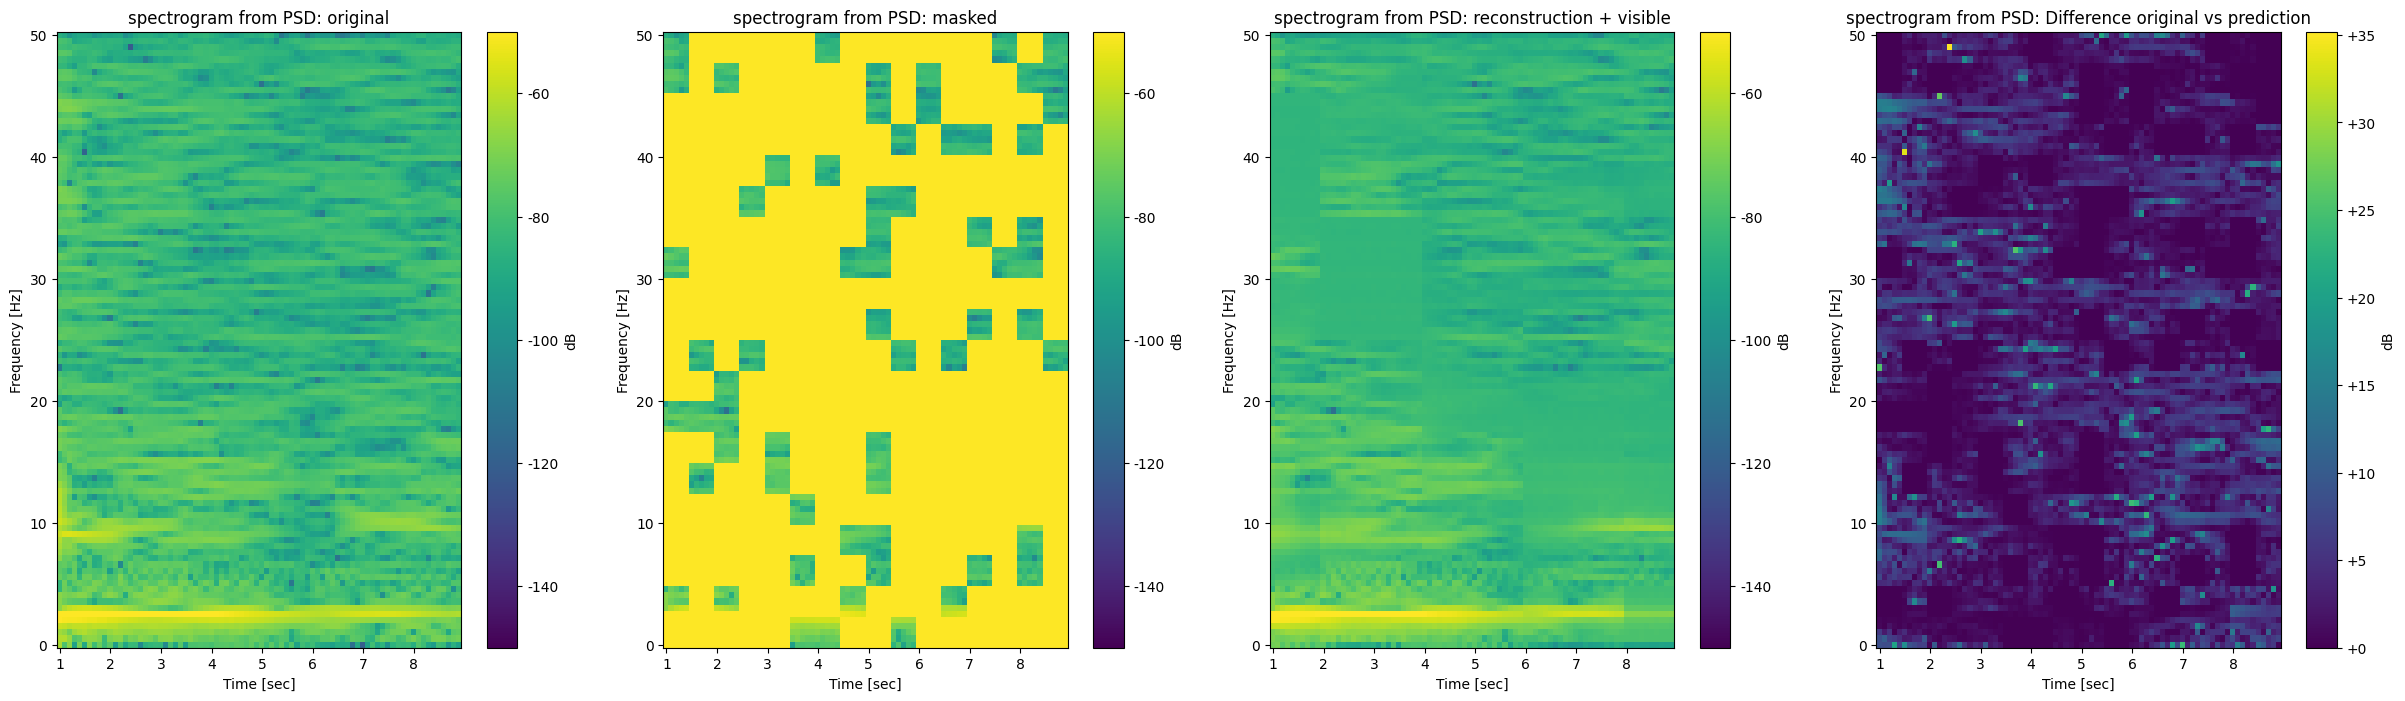

In [61]:
frequencies, times, spectrogram = generator[positives[169]]
run_one_image(frequencies, times, spectrogram, model_mae, False)

Pre intervention

In [14]:
data_path = "/home/yhbedoya/Repositories/SHM-MAE/INSIST_SS335/"
generator = SHMDataset(data_path=data_path, post=False)

preMSE = []
preOrMSE = []
for index in tqdm(range(0, 10000)):
  frequencies, times, spectrogram = generator[index]
  out = run_one_image(frequencies, times, spectrogram, model_mae, True)
  preMSE.append(out[0])
  preOrMSE.append(out[1])

with open('preMSE.pkl', 'wb') as f:
    pickle.dump([preMSE, preOrMSE], f)

reading CSV files
Creating the dataframe


100%|██████████| 862491/862491 [01:45<00:00, 8187.99it/s] 


Finish data reading
start partitioner
Generating windows


100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


Defining useful windows limits


  0%|          | 0/862438 [00:00<?, ?it/s]/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  4%|▎         | 30737/862438 [00:13<06:16, 2208.86it/s]


Total windows in dataset: 10000
Total positive instances: 5000
Total noisy instances: 5001
Proportion of useful instances 0.011596195900458931
General min: -19.989953906161176
General max: -0.3470934974967436


100%|██████████| 10000/10000 [15:54<00:00, 10.47it/s]


In [65]:
import pickle

with open('postMSETrain.pkl', "rb") as f:  # Python 3: open(..., 'rb')
    postMSE, postOrMSE = pickle.load(f)

with open('preMSE.pkl', "rb") as f:  # Python 3: open(..., 'rb')
    preMSE, preOrMSE = pickle.load(f)

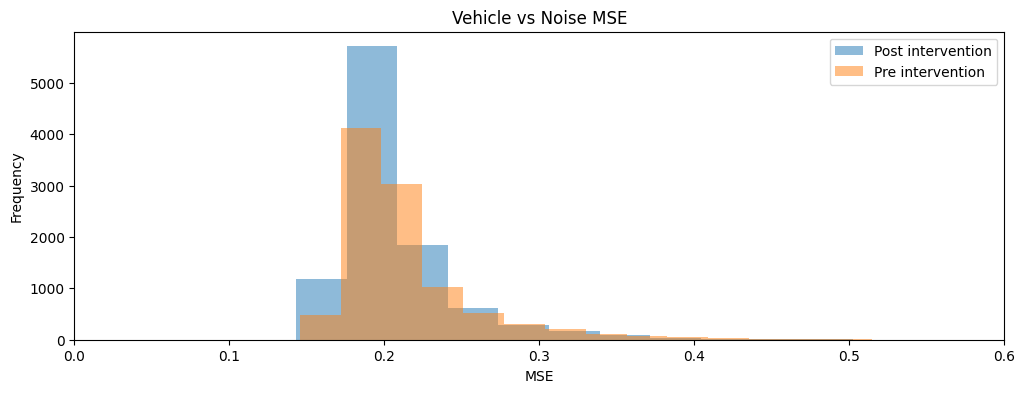

In [67]:
plt.figure(figsize=(12,4))
plt.hist(postMSE, bins=50, alpha=0.5, label='Post intervention')
plt.hist(preMSE, bins=50, alpha=0.5, label='Pre intervention')
plt.title("Vehicle vs Noise MSE")
plt.legend(loc='upper right')
plt.xlabel("MSE")
plt.xlim([0, 0.6])
plt.ylabel("Frequency")
plt.show()

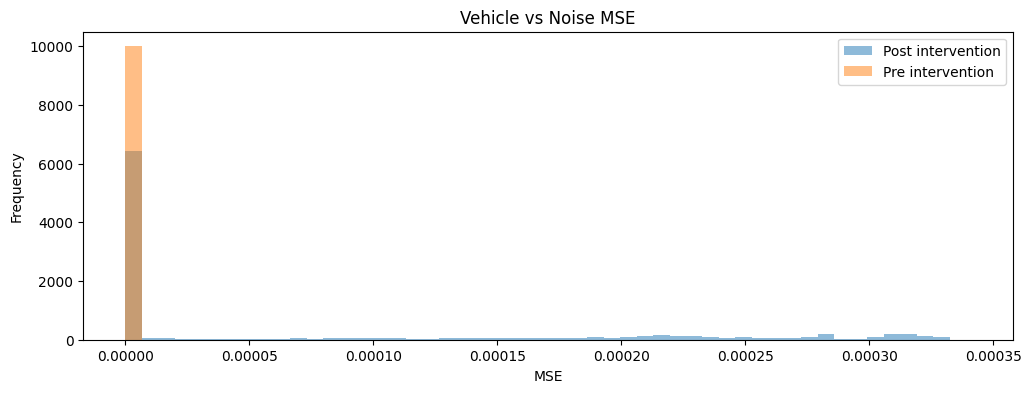

In [8]:
plt.figure(figsize=(12,4))
plt.hist(postOrMSE, bins=50, alpha=0.5, label='Post intervention')
plt.hist(preOrMSE, bins=50, alpha=0.5, label='Pre intervention')
plt.title("Vehicle vs Noise MSE")
plt.legend(loc='upper right')
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.show()

<AxesSubplot:xlabel='Moment', ylabel='MSE'>

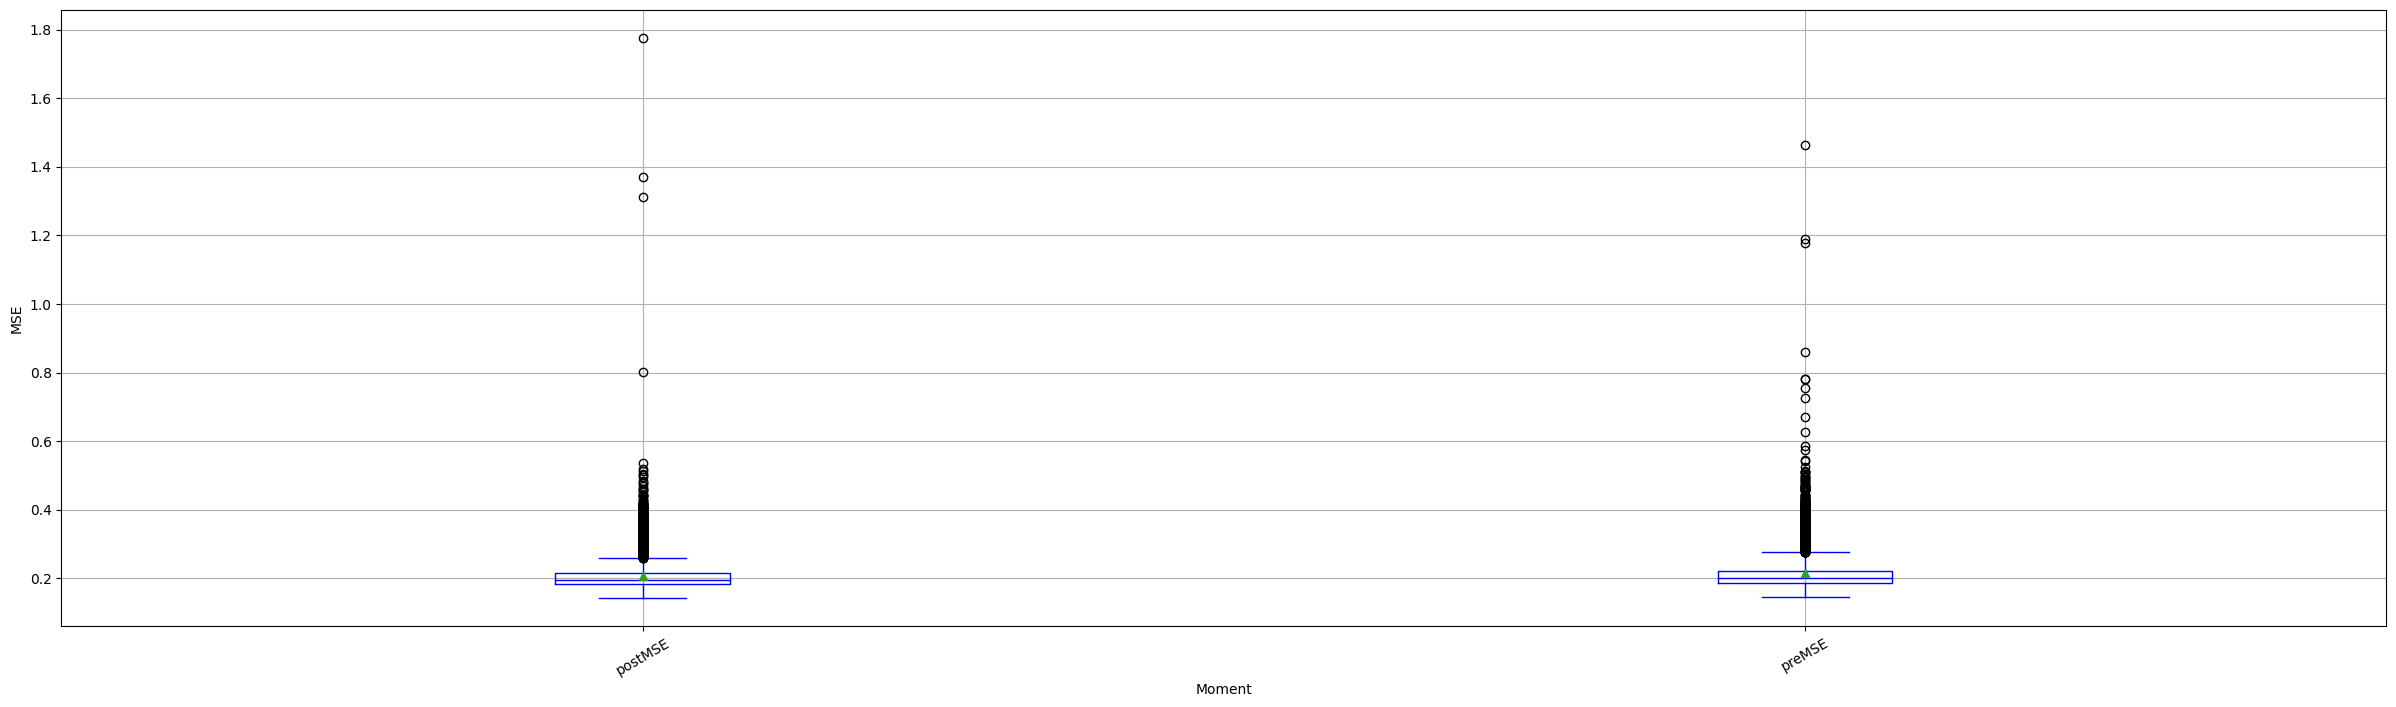

In [68]:
import matplotlib.pyplot as plt
import pandas as pd

plt.ylabel("MSE")
plt.xlabel("Moment")
data = pd.DataFrame(np.array([postMSE, preMSE]).T, columns=["postMSE", "preMSE"])
plt.rcParams['figure.figsize'] = (8,4)
data.boxplot(column=['postMSE', 'preMSE'], grid='true', color='blue',fontsize=10, rot=30, showmeans=True)


### Finetunning

In [ ]:
from main_finetune import get_args_parser as get_args_parser_ft
from main_finetune import main as main_ft
from pathlib import Path

In [ ]:
args = get_args_parser_ft()
args.add_argument('-f')
args = args.parse_args()

In [ ]:
if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)